In [ ]:
!pip install pytorch-lightning-bolts

In [100]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/test')

import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchvision.datasets import MNIST
from torchvision import transforms

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
IMAGE_SHAPE = (1, 28, 28)
IMAGE_SIZE = int(np.prod(IMAGE_SHAPE))
LATENT_DIM = 100
N_CLASSES = 10
LEARN_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

In [102]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_embed = nn.Embedding(N_CLASSES, N_CLASSES)

        def block(in_features, out_features, normalize=True):
            layers = [nn.Linear(in_features, out_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        hidden_size = 256
        self.net = nn.Sequential(
            *block(N_CLASSES + LATENT_DIM, hidden_size, normalize=False),
            *block(hidden_size, hidden_size*2),
            *block(hidden_size*2, hidden_size*4),
            nn.Linear(hidden_size*4, IMAGE_SIZE),
            nn.Tanh()
        )

    def forward(self, noise, label):
        input_data = torch.cat((self.label_embed(label), noise), dim=1)
        return self.net(input_data)

In [103]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_embed = nn.Embedding(N_CLASSES, N_CLASSES)

        def block(in_features, out_features, dropout=True):
            layers = [nn.Linear(in_features, out_features)]
            if dropout:
                layers.append(nn.Dropout(0.4))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        hidden_size = 1024
        self.net = nn.Sequential(
            *block(N_CLASSES + IMAGE_SIZE, hidden_size, dropout=False),
            *block(hidden_size, hidden_size//2),
            *block(hidden_size//2, hidden_size//4),
            nn.Linear(hidden_size//4, 1)
        )

    def forward(self, image, label):
        image = image.view(image.size(0), -1)
        input_data = torch.cat((image, self.label_embed(label)), dim=1)
        return self.net(input_data)

In [104]:
class GANModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.adversarial_loss = nn.MSELoss()
        self.G_image = None
        self.G_image_label = None

    def forward(self, noise, label):
        return self.generator(noise, label)

    def training_step(self, batch, batch_idx, optimizer_idx):
        image, label = batch
        batch_size = image.size(0)
        real = torch.ones(batch_size, 1).cuda()
        fake = torch.zeros(batch_size, 1).cuda()

        if optimizer_idx == 0:
            random_noise = torch.rand(batch_size, LATENT_DIM).cuda()
            self.G_image_label = torch.randint(N_CLASSES, (batch_size,)).cuda()

            self.G_image = self.generator(random_noise, self.G_image_label)
            D_pred = self.discriminator(self.G_image, self.G_image_label)
            loss = self.adversarial_loss(D_pred, real)

        if optimizer_idx == 1:
            D_pred_real = self.discriminator(image, label)
            loss_real = self.adversarial_loss(D_pred_real, real)
            
            self.G_image = self.G_image.detach()
            D_pred_fake = self.discriminator(self.G_image, self.G_image_label)
            loss_fake = self.adversarial_loss(D_pred_fake, fake)

            loss = (loss_real + loss_fake) / 2
        return loss

    def configure_optimizers(self):
        return [torch.optim.Adam(self.generator.parameters(),
                                 lr=LEARN_RATE, betas=(BETA1, BETA2)),
                torch.optim.Adam(self.discriminator.parameters(),
                                 lr=LEARN_RATE, betas=(BETA1, BETA2))]

    def train_dataloader(self):
        process = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5], [0.5])])
        train_dataset = MNIST(os.getcwd(), train=True, transform=process,
                              download=True)
        return DataLoader(train_dataset, batch_size=64, shuffle=True)

In [112]:
model = GANModel()
trainer = pl.Trainer(max_epochs=200, gpus=1, precision=16, progress_bar_refresh_rate=60)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [ ]:
trainer.fit(model)


  | Name             | Type          | Params
---------------------------------------------------
0 | generator        | Generator     | 1.5 M 
1 | discriminator    | Discriminator | 1.5 M 
2 | adversarial_loss | MSELoss       | 0     
---------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params


In [107]:
model.eval()

def get_dataloader():
    process = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize([0.5], [0.5])])
    train_dataset = MNIST(os.getcwd(), train=True, transform=process,
                          download=True)
    return DataLoader(train_dataset, batch_size=1, shuffle=True)


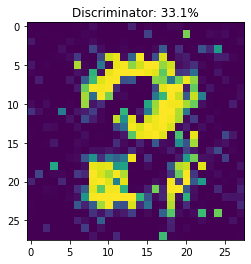

In [108]:
random_noise = torch.randn(1, LATENT_DIM)
label = torch.LongTensor([7])
y_pred = model(random_noise, label)
score = model.discriminator(y_pred, label).item()

plt.title(f"Discriminator: {score * 100:.1f}%")
plt.imshow(y_pred.detach().view(28, 28))
plt.show()

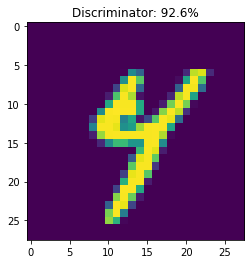

In [109]:
dataset = get_dataloader()
image, label = iter(dataset).next()

score = model.discriminator(image, label).item()

plt.title(f"Discriminator: {score * 100:.1f}%")
plt.imshow(image.view(28, 28))
plt.show()